## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import gc

import matplotlib.pyplot as plt
import json
import pandas as pd
import time
from adamp import AdamP

In [2]:
os.getpid()

1103849

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [6]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [7]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_DIR = os.path.join(ROOT_PATH, 'test')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')
EXAMPLE_DIR = os.path.join(ROOT_PATH, 'example')
SR_EXAMPLE_DIR = os.path.join(ROOT_PATH, 'example_SR')
SR_TRAIN_DIR = os.path.join(ROOT_PATH, 'train_SR')
SR_TEST_DIR = os.path.join(ROOT_PATH, 'test_SR')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-8
EARLY_STOPPING_PATIENCE = 5
INPUT_SHAPE = (480, 240)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Try Super-Resolution

In [8]:
from ISR.models import RDN, RRDN

rdn = RDN(weights='psnr-large')

rrdn = RRDN(weights='gans')

In [9]:
filenames = os.listdir(EXAMPLE_DIR)
filenames = [f for f in filenames if not f[0] == '.']
filenames

['x4_nomask3.png',
 'x2_nomask3.png',
 'nomask2.png',
 'x2_nomask2.png',
 'x2_nomask1.png',
 'x4_nomask1.png',
 'x4_mask1.png',
 'x2_mask2.png',
 'x2_mask1.png',
 'x4_nomask2.png',
 'x4_mask2.png',
 'mask1.png',
 'x4_mask3.png',
 'nomask1.png',
 'x2_mask4.png',
 'nomask4.png',
 'x4_nomask4.png',
 'x2_nomask4.png',
 'mask2.png',
 'mask3.png',
 'mask4.png',
 'nomask3.png',
 'x2_mask3.png',
 'x4_mask4.png']

In [27]:
for f in filenames:
    IM_PATH = os.path.join(EXAMPLE_DIR, f)
    im = cv2.imread(IM_PATH)
    
    rdn_im = rdn.predict(im)
    rrdn_im = rrdn.predict(im)
    
    cv2.imwrite(os.path.join(SR_EXAMPLE_DIR, f'rdn_{f}'), rdn_im)
    cv2.imwrite(os.path.join(SR_EXAMPLE_DIR, f'rrdn_{f}'), rdn_im)

In [32]:
for f in filenames:
    IM_PATH = os.path.join(EXAMPLE_DIR, f)
    im = cv2.imread(IM_PATH)
    h, w, _ = im.shape
    
    x2_im = cv2.resize(im, (w*2, h*2), cv2.INTER_LINEAR)
    x4_im = cv2.resize(im, (w*4, h*4), cv2.INTER_LINEAR)
    
    cv2.imwrite(os.path.join(EXAMPLE_DIR, f'x2_{f}'), x2_im)
    cv2.imwrite(os.path.join(EXAMPLE_DIR, f'x4_{f}'), x4_im)

## Create SR Dataset

In [ ]:
filenames = os.listdir(os.path.join(TRAIN_DIR,"Mask"))
filenames = [f for f in filenames if not f[0] == '.']
filenames

In [ ]:
for f in filenames:
    IM_PATH = os.path.join(TRAIN_DIR, f'Mask/{f}')
    im = cv2.imread(IM_PATH)
    
    rdn_im = rdn.predict(im)
    
    cv2.imwrite(os.path.join(SR_TRAIN_DIR, f'Mask/{f}'), rdn_im)

In [ ]:
filenames = os.listdir(os.path.join(TRAIN_DIR,"NoMask"))
filenames = [f for f in filenames if not f[0] == '.']
filenames

In [11]:
for f in filenames:
    IM_PATH = os.path.join(TRAIN_DIR, f'NoMask/{f}')
    im = cv2.imread(IM_PATH)
    
    rdn_im = rdn.predict(im)
    
    cv2.imwrite(os.path.join(SR_TRAIN_DIR, f'NoMask/{f}'), rdn_im)

In [12]:
filenames = os.listdir(TEST_DIR)
filenames = [f for f in filenames if not f[0] == '.']
filenames

['619.png',
 '700.png',
 '143.png',
 '345.png',
 '244.png',
 '52.png',
 '823.png',
 '477.png',
 '857.png',
 '987.png',
 '922.png',
 '242.png',
 '40.png',
 '918.png',
 '721.png',
 '651.png',
 '594.png',
 '606.png',
 '663.png',
 '155.png',
 '1002.png',
 '508.png',
 '32.png',
 '339.png',
 '502.png',
 '458.png',
 '509.png',
 '325.png',
 '577.png',
 '188.png',
 '578.png',
 '121.png',
 '467.png',
 '727.png',
 '488.png',
 '677.png',
 '1005.png',
 '352.png',
 '332.png',
 '622.png',
 '841.png',
 '10.png',
 '318.png',
 '989.png',
 '441.png',
 '390.png',
 '652.png',
 '228.png',
 '400.png',
 '912.png',
 '23.png',
 '102.png',
 '634.png',
 '90.png',
 '168.png',
 '487.png',
 '813.png',
 '89.png',
 '746.png',
 '992.png',
 '702.png',
 '209.png',
 '349.png',
 '924.png',
 '202.png',
 '115.png',
 '473.png',
 '36.png',
 '334.png',
 '25.png',
 '20.png',
 '800.png',
 '157.png',
 '596.png',
 '538.png',
 '193.png',
 '816.png',
 '359.png',
 '631.png',
 '797.png',
 '812.png',
 '342.png',
 '636.png',
 '637.png',


In [13]:
for f in filenames:
    IM_PATH = os.path.join(TEST_DIR, f)
    im = cv2.imread(IM_PATH)
    
    rdn_im = rdn.predict(im)
    
    cv2.imwrite(os.path.join(SR_TEST_DIR, f), rdn_im)

## Dataloader

#### Train & Validation Set loader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform
        self.autoaugment = transforms.RandomApply(nn.ModuleList([
            transforms.AutoAugment()
        ]), p=0.5)

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))
        trans_image = TF.crop(trans_image, 0,0,INPUT_SHAPE[1], INPUT_SHAPE[1])
        trans_image = self.autoaugment(trans_image)
        
        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [54]:
train_dataset = CustomDataset(db=train_db, mode='train', transform=transform)
validation_dataset = CustomDataset(db=valid_db, mode='val', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [55]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [56]:
import timm

In [57]:
# timm.list_models(pretrained=True)

In [58]:
EFF_BACKBONES = [
    'tf_efficientnetv2_l_in21kft1k'
    'tf_efficientnetv2_m_in21ft1k',
    'tf_efficientnetv2_s_in21ft1k'
]
NFN_BACKBONES = [
    'eca_nfnet_l1',
    'eca_nfnet_l2',
    'dm_nfnet_f0',
    'dm_nfnet_f1'    
    
]
    
DEIT_BACKBONES = [
    'deit_base_distilled_patch16_224',
    'deit_base_distilled_patch16_384'   
]  

In [59]:
# # lighter models to experiment on

# EFF_BACKBONES = [
#     'tf_efficientnet_b5_ns',
#     'tf_efficientnet_b6_ns',
#     'tf_efficientnet_b7_ns',
#     'efficientnetv2_rw_s',
#     'efficientnetv2_rw_m',
#     'tf_efficientnetv2_s_in21k',
#     'tf_efficientnetv2_s_in21ft1k',
#     'tf_efficientnetv2_m_in21k',
#     'tf_efficientnetv2_m_in21ft1k'
# ]
# NFN_BACKBONES = [
#     'eca_nfnet_l0',
#     'eca_nfnet_l1',
#     'eca_nfnet_l2'
# ]

In [60]:
class DebuggerNet(nn.Module):
    def __init__(self):
        super(DebuggerNet, self).__init__()
        self.conv = nn.Conv2d(3, 3, 3, 3)
        self.avgpool = nn.AdaptiveAvgPool2d(2)
        self.linear = nn.Linear(12, 2)

    def forward(self, input_img):
        x = self.avgpool(input_img)

        x = x.view(-1, 12)
        x = self.linear(x)
        return x


In [61]:
from torch.nn import functional as F
# for efficientnet
class EFFMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(EFFMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x


In [62]:
# for nfnet
class NFNMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(NFNMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

In [63]:
# for deit
class DEITMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(DEITMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        in_features_head = self.model.head.in_features
        in_features_head_dist = self.model.head_dist.in_features
        
        self.model.head = nn.Linear(in_features_head, 2)
        self.model.head_dist = nn.Linear(in_features_head_dist, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## Just Trainer

In [64]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            pred = F.softmax(pred)

            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            pred = F.softmax(pred)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)


## SAM Optimizer w. AdamP

In [65]:
class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None: continue
                e_w = p.grad * scale.to(p)
                p.add_(e_w)  # climb to the local maximum "w + e(w)"
                self.state[p]["e_w"] = e_w

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.sub_(self.state[p]["e_w"])  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
                    torch.stack([
                        p.grad.norm(p=2).to(shared_device)
                        for group in self.param_groups for p in group["params"]
                        if p.grad is not None
                    ]),
                    p=2
               )
        return norm

## MultiScale Trainer

In [66]:
class MultiScale_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, scales, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.scales = scales
        self.scales_max_index = len(self.scales) - 1
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = TF.resize(img, self.scales[np.random.randint(0, self.scales_max_index)])
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


# SAM Trainer

In [67]:
class SAM_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
        
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            loss.backward()
            self.optimizer.first_step(zero_grad=True)
            self.criterion(self.model(img), label).backward()
            self.optimizer.second_step(zero_grad=True)
            
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [68]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [69]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

#### Test set Loader

In [70]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [71]:
class CheckDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [72]:
def check_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [73]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = check_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [74]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [75]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [76]:
check_dataset = CheckDataset(db=test_db, mode='check', transform=transform)
check_dataloader = DataLoader(check_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [77]:
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


# Misc.

In [78]:
def plot_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

In [79]:
def wait_and_flush():
    
    print("waiting...")
    
    time.sleep(120)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("flushing...")
    time.sleep(60)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("done!")

In [80]:
def pretty_size(size):

    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

# dump_tensors()

# 학습 Function

In [81]:
def EFF_train_val_infer(BACKBONE):
    model = EFFMaskClassifier(BACKBONE).to(device)
    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-7)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_acc_history, valid_acc_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v2.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}

    
    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v2_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

In [83]:
def NFN_train_val_infer(BACKBONE):
    model = NFNMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=5e-6, last_epoch=-1)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    patience = 0
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper
        patience += 1
        
        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            patience = 0
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v3_best.pt'))
        
        if patience == EARLY_STOPPING_PATIENCE:
            break
            
    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v3_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())


    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v3.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v3_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)

    wait_and_flush()

In [84]:
def DEIT_train_val_infer(BACKBONE):
    model = DEITMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_SAM_AdamP_v2_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}_SAM_AdamP_v2.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'SAM, AdamP',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_SAM_AdamP_v2_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

# Debugging Purposes

In [85]:
def DEBUG_train_val_infer(BACKBONE="debug"):
    model = DebuggerNet().to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    base_optimizer = AdamP
    optimizer = SAM(model.parameters(), base_optimizer, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = SAM_Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

In [86]:
# DEBUG_train_val_infer()

# 기차 = Train

In [87]:
save_csv = pd.DataFrame()

# Efficient Family

In [43]:
print(len(EFF_BACKBONES))
print(EFF_BACKBONES)

2
['tf_efficientnetv2_l_in21kft1ktf_efficientnetv2_m_in21ft1k', 'tf_efficientnetv2_s_in21ft1k']


In [43]:
INDEX = 0

In [ ]:
EFF_train_val_infer(EFF_BACKBONES[INDEX])


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#0
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#1
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except: 
    pass
INDEX += 1

In [ ]:
#2
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [152]:
#3
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b4_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]


In [153]:
#4
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b7_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]


In [154]:
#5
try:
    p
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_s_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2690994963722103, Acc: 0.8830162374938494, ROC: 0.9550191694620239
Epoch 0, Val loss: 0.1369138987756957, Acc: 0.9494464944649447, ROC: 0.9891635630449913


  5%|▌         | 1/20 [03:47<1:12:10, 227.93s/it]

Epoch 1, Train loss: 0.07001862173494847, Acc: 0.9756027554535017, ROC: 0.9967132585242402
Epoch 1, Val loss: 0.10814163018467136, Acc: 0.9638376383763838, ROC: 0.9931559638856023


 10%|█         | 2/20 [07:29<1:07:12, 224.00s/it]

Epoch 2, Train loss: 0.025931142009298955, Acc: 0.9924553058881417, ROC: 0.9994499970867791
Epoch 2, Val loss: 0.09895637870506871, Acc: 0.9675276752767528, ROC: 0.9947135797914521


 15%|█▌        | 3/20 [11:19<1:04:17, 226.89s/it]

Epoch 3, Train loss: 0.01825464988442537, Acc: 0.9939724454649828, ROC: 0.9997701383316224


 20%|██        | 4/20 [15:13<1:01:13, 229.59s/it]

Epoch 3, Val loss: 0.11790847023747539, Acc: 0.9671586715867159, ROC: 0.9934396227392974
Epoch 4, Train loss: 0.01892886365010476, Acc: 0.9934393964244711, ROC: 0.9996654337012689
Epoch 4, Val loss: 0.09449502742704977, Acc: 0.9708487084870848, ROC: 0.9951571798848534


 25%|██▌       | 5/20 [19:04<57:31, 230.09s/it]  

Epoch 5, Train loss: 0.0118492641546022, Acc: 0.9961456453993768, ROC: 0.9998860720046397


 30%|███       | 6/20 [22:57<53:54, 231.06s/it]

Epoch 5, Val loss: 0.10210167615531586, Acc: 0.9686346863468634, ROC: 0.9959474122120431
Epoch 6, Train loss: 0.012980398986086598, Acc: 0.9957356076759062, ROC: 0.9998604282288995


 35%|███▌      | 7/20 [26:47<50:02, 230.94s/it]

Epoch 6, Val loss: 0.13257748890717094, Acc: 0.9675276752767528, ROC: 0.9946985330546158
Epoch 7, Train loss: 0.009681163648271054, Acc: 0.9966376906675414, ROC: 0.9999107628254726


 40%|████      | 8/20 [30:43<46:29, 232.49s/it]

Epoch 7, Val loss: 0.09796598003250914, Acc: 0.9752767527675277, ROC: 0.9964617876972306
Epoch 8, Train loss: 0.009628427977952336, Acc: 0.9965966868951943, ROC: 0.9999257589642507


 45%|████▌     | 9/20 [34:34<42:32, 232.03s/it]

Epoch 8, Val loss: 0.12571307098053924, Acc: 0.9682656826568266, ROC: 0.9943647184114658
Epoch 9, Train loss: 0.008961254097712382, Acc: 0.9968017057569296, ROC: 0.999932625744017
Epoch 9, Val loss: 0.09237290333977834, Acc: 0.9767527675276753, ROC: 0.9961965192996691


 50%|█████     | 10/20 [38:25<38:35, 231.55s/it]

Epoch 10, Train loss: 0.007052849406741753, Acc: 0.9974987698868296, ROC: 0.9999569725378075


 55%|█████▌    | 11/20 [42:18<34:48, 232.02s/it]

Epoch 10, Val loss: 0.1053045963609944, Acc: 0.9767527675276753, ROC: 0.9960131720248839
Epoch 11, Train loss: 0.00878785530221477, Acc: 0.9977037887485649, ROC: 0.9998298545456417


 60%|██████    | 12/20 [46:09<30:54, 231.77s/it]

Epoch 11, Val loss: 0.14617086801494825, Acc: 0.9738007380073801, ROC: 0.9937979579906253
Epoch 12, Train loss: 0.006968123596797182, Acc: 0.997867803837953, ROC: 0.9999014224912716


 65%|██████▌   | 13/20 [50:01<27:03, 231.89s/it]

Epoch 12, Val loss: 0.10475690941317137, Acc: 0.9797047970479705, ROC: 0.99620655045756
Epoch 13, Train loss: 0.006531283198195965, Acc: 0.997785796293259, ROC: 0.9999624150456181


 70%|███████   | 14/20 [53:57<23:18, 233.04s/it]

Epoch 13, Val loss: 0.10836163981216944, Acc: 0.9763837638376384, ROC: 0.9956866021068775
Epoch 14, Train loss: 0.006026070486504916, Acc: 0.9981548302443825, ROC: 0.9999698597908155


 75%|███████▌  | 15/20 [57:26<18:49, 225.86s/it]

Epoch 14, Val loss: 0.09552705808764202, Acc: 0.977490774907749, ROC: 0.9963564605393753
Epoch 15, Train loss: 0.005245255320654283, Acc: 0.9984418566508119, ROC: 0.9999376072555908


 80%|████████  | 16/20 [1:00:55<14:43, 220.83s/it]

Epoch 15, Val loss: 0.1147591334033452, Acc: 0.9767527675276753, ROC: 0.9955227598613249
Epoch 16, Train loss: 0.006103254306500758, Acc: 0.997744792520912, ROC: 0.999911220381439


 85%|████████▌ | 17/20 [1:04:24<10:51, 217.13s/it]

Epoch 16, Val loss: 0.11835005406277904, Acc: 0.977859778597786, ROC: 0.9948701773118614
Epoch 17, Train loss: 0.005621464211463556, Acc: 0.9983188453337707, ROC: 0.9999513752178277


 90%|█████████ | 18/20 [1:07:53<07:09, 214.65s/it]

Epoch 17, Val loss: 0.10377853260014, Acc: 0.9715867158671587, ROC: 0.996047723790953
Epoch 18, Train loss: 0.0038045735975065255, Acc: 0.9989339019189766, ROC: 0.9999731177269071


 95%|█████████▌| 19/20 [1:11:14<03:30, 210.78s/it]

Epoch 18, Val loss: 0.10172782234855554, Acc: 0.977859778597786, ROC: 0.9964718188551216
Epoch 19, Train loss: 0.008941931519371208, Acc: 0.9982778415614236, ROC: 0.9999092456662156
Epoch 19, Val loss: 0.09125039057337976, Acc: 0.9738007380073801, ROC: 0.9970597561648431


100%|██████████| 20/20 [1:14:39<00:00, 223.99s/it]


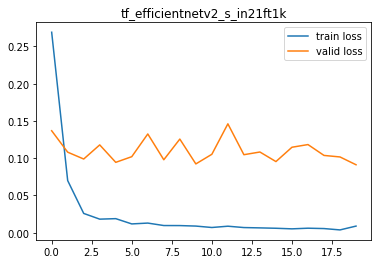

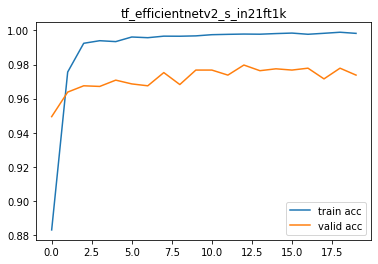

Epoch 0, Val loss: 1.054912937574045, Acc: 0.8323586744639376, ROC: 0.8988378594249201
waiting...
flushing...
done!


In [44]:
#6
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [45]:
gc.collect()
torch.cuda.empty_cache()

In [60]:
INDEX = 7

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.23040451882333737, Acc: 0.9049122519271773, ROC: 0.9672700137250276
Epoch 0, Val loss: 0.0916665866943462, Acc: 0.966789667896679, ROC: 0.9938102182947143


  5%|▌         | 1/20 [05:12<1:39:03, 312.80s/it]

Epoch 1, Train loss: 0.05378244245190967, Acc: 0.9826964080695424, ROC: 0.9978260621566593


 10%|█         | 2/20 [10:30<1:34:38, 315.47s/it]

Epoch 1, Val loss: 0.09506944368645748, Acc: 0.9715867158671587, ROC: 0.9938949258502381
Epoch 2, Train loss: 0.02315388641113654, Acc: 0.9929063473839593, ROC: 0.9995539207757465


 15%|█▌        | 3/20 [15:44<1:29:11, 314.78s/it]

Epoch 2, Val loss: 0.10514493812304045, Acc: 0.9715867158671587, ROC: 0.9941752409846362
Epoch 3, Train loss: 0.024402999474226472, Acc: 0.9932343775627358, ROC: 0.9995413741095099


 20%|██        | 4/20 [20:59<1:23:59, 314.99s/it]

Epoch 3, Val loss: 0.09383790971543887, Acc: 0.9734317343173432, ROC: 0.995733971463585
Epoch 4, Train loss: 0.01715349357192016, Acc: 0.9942184680990651, ROC: 0.9997629481664362


 25%|██▌       | 5/20 [26:13<1:18:41, 314.74s/it]

Epoch 4, Val loss: 0.10809329145046277, Acc: 0.9712177121771217, ROC: 0.9945564249844935
Epoch 5, Train loss: 0.01521569874777084, Acc: 0.9953665737247827, ROC: 0.9997582659583892


 30%|███       | 6/20 [31:26<1:13:17, 314.13s/it]

Epoch 5, Val loss: 0.09574745200986867, Acc: 0.9763837638376384, ROC: 0.9956498211946105
Epoch 6, Train loss: 0.013415080435334664, Acc: 0.9958176152206003, ROC: 0.9998231012947995


 35%|███▌      | 7/20 [36:43<1:08:14, 314.98s/it]

Epoch 6, Val loss: 0.11499588348495028, Acc: 0.9734317343173432, ROC: 0.9948668335925644
Epoch 7, Train loss: 0.01059136049281931, Acc: 0.9965966868951943, ROC: 0.999825158576513


 40%|████      | 8/20 [41:57<1:02:55, 314.66s/it]

Epoch 7, Val loss: 0.10202262118788018, Acc: 0.9686346863468634, ROC: 0.9949554421539348
Epoch 8, Train loss: 0.010187504791173191, Acc: 0.9967196982122355, ROC: 0.9998908677416107
Epoch 8, Val loss: 0.08088731026366626, Acc: 0.9782287822878228, ROC: 0.9965537399778981


 45%|████▌     | 9/20 [47:11<57:38, 314.41s/it]  

Epoch 9, Train loss: 0.008976509305612864, Acc: 0.9971707397080531, ROC: 0.9998558526692356


 50%|█████     | 10/20 [52:27<52:28, 314.87s/it]

Epoch 9, Val loss: 0.0969818012591214, Acc: 0.9785977859778597, ROC: 0.9965247610773241
Epoch 10, Train loss: 0.007530916798072179, Acc: 0.9976627849762179, ROC: 0.9999062251087835


 55%|█████▌    | 11/20 [57:38<47:04, 313.79s/it]

Epoch 10, Val loss: 0.13419255576937064, Acc: 0.9756457564575646, ROC: 0.9931855000727259
Epoch 11, Train loss: 0.010659916575774354, Acc: 0.9967607019845826, ROC: 0.999805521512933


 60%|██████    | 12/20 [1:02:50<41:45, 313.24s/it]

Epoch 11, Val loss: 0.09007899651791937, Acc: 0.9771217712177122, ROC: 0.9956057955572002
Epoch 12, Train loss: 0.005541651132028265, Acc: 0.9982778415614236, ROC: 0.9999761589259618


 65%|██████▌   | 13/20 [1:08:06<36:39, 314.17s/it]

Epoch 12, Val loss: 0.08992585668673297, Acc: 0.977490774907749, ROC: 0.9963481012411328
Epoch 13, Train loss: 0.006917214749407618, Acc: 0.9977037887485649, ROC: 0.9999482996160686


 70%|███████   | 14/20 [1:13:18<31:21, 313.53s/it]

Epoch 13, Val loss: 0.12756079045810248, Acc: 0.9797047970479705, ROC: 0.9947341993937837
Epoch 14, Train loss: 0.006212290413556522, Acc: 0.9980318189273413, ROC: 0.9999538350111807


 75%|███████▌  | 15/20 [1:18:30<26:04, 312.97s/it]

Epoch 14, Val loss: 0.1528338355768636, Acc: 0.9682656826568266, ROC: 0.9948846667621484
Epoch 15, Train loss: 0.006435129814670494, Acc: 0.9981138264720354, ROC: 0.9999262922061665


 80%|████████  | 16/20 [1:23:46<20:54, 313.75s/it]

Epoch 15, Val loss: 0.0920319749183977, Acc: 0.9793357933579335, ROC: 0.9966484786913128
Epoch 16, Train loss: 0.006602643424377331, Acc: 0.9982778415614236, ROC: 0.9998955017858719


 85%|████████▌ | 17/20 [1:28:58<15:40, 313.41s/it]

Epoch 16, Val loss: 0.09033721673918699, Acc: 0.9785977859778597, ROC: 0.9964623449837801
Epoch 17, Train loss: 0.00479275962288336, Acc: 0.9984418566508119, ROC: 0.999983713759813


 90%|█████████ | 18/20 [1:34:15<10:29, 314.55s/it]

Epoch 17, Val loss: 0.1094315813451748, Acc: 0.9756457564575646, ROC: 0.9960544112295469
Epoch 18, Train loss: 0.005019757277130259, Acc: 0.998564867967853, ROC: 0.9999427676612268


 95%|█████████▌| 19/20 [1:39:28<05:14, 314.06s/it]

Epoch 18, Val loss: 0.08642782892026504, Acc: 0.9819188191881919, ROC: 0.9966390048199713
Epoch 19, Train loss: 0.003714175139480895, Acc: 0.9988518943742825, ROC: 0.9999877732789133


100%|██████████| 20/20 [1:44:36<00:00, 313.84s/it]

Epoch 19, Val loss: 0.10329206273798919, Acc: 0.9833948339483395, ROC: 0.9970926360712636


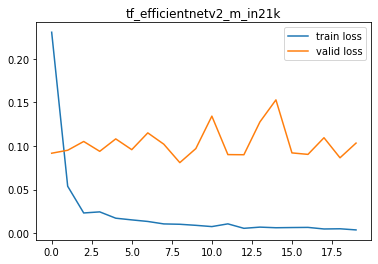

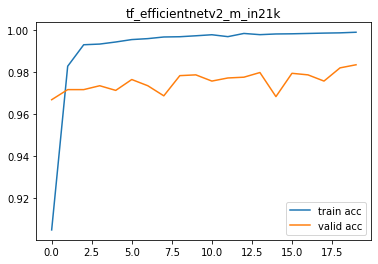

Epoch 0, Val loss: 0.8827640795284424, Acc: 0.8508771929824561, ROC: 0.9136501597444089
waiting...
flushing...
done!


In [61]:
#7
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2303688326823645, Acc: 0.9058553386911596, ROC: 0.9674390135693347
Epoch 0, Val loss: 0.11400873232192013, Acc: 0.9560885608856089, ROC: 0.9927586185758096


  5%|▌         | 1/20 [04:43<1:29:43, 283.32s/it]

Epoch 1, Train loss: 0.061543408215178536, Acc: 0.979457110054125, ROC: 0.9972231238024246
Epoch 1, Val loss: 0.09743797951433036, Acc: 0.9634686346863469, ROC: 0.994014185171831


 10%|█         | 2/20 [09:27<1:25:04, 283.61s/it]

Epoch 2, Train loss: 0.026827172735747546, Acc: 0.9913482040347712, ROC: 0.9993945296067334
Epoch 2, Val loss: 0.08296394555379089, Acc: 0.970110701107011, ROC: 0.9957635076507083


 15%|█▌        | 3/20 [14:09<1:20:13, 283.12s/it]

Epoch 3, Train loss: 0.022028883599450946, Acc: 0.9930703624733476, ROC: 0.9995956615768004


 20%|██        | 4/20 [18:50<1:15:17, 282.33s/it]

Epoch 3, Val loss: 0.11076528280432689, Acc: 0.9693726937269372, ROC: 0.9938191348795062
Epoch 4, Train loss: 0.01915666852720837, Acc: 0.9940544530096769, ROC: 0.9996840730864259


 25%|██▌       | 5/20 [23:29<1:10:15, 281.01s/it]

Epoch 4, Val loss: 0.10325843614178483, Acc: 0.9715867158671587, ROC: 0.99511649796674
Epoch 5, Train loss: 0.012637169782378077, Acc: 0.9963506642611121, ROC: 0.9998338555801448


 30%|███       | 6/20 [28:11<1:05:41, 281.51s/it]

Epoch 5, Val loss: 0.10941753287114855, Acc: 0.9726937269372694, ROC: 0.9943223646337038
Epoch 6, Train loss: 0.013608785447029712, Acc: 0.9952845661800885, ROC: 0.9998518069112171


 35%|███▌      | 7/20 [32:49<1:00:41, 280.10s/it]

Epoch 6, Val loss: 0.09094908463674117, Acc: 0.9760147601476015, ROC: 0.9967225978023961
Epoch 7, Train loss: 0.012541033636902585, Acc: 0.9961456453993768, ROC: 0.9998013794273426


 40%|████      | 8/20 [37:27<55:55, 279.60s/it]  

Epoch 7, Val loss: 0.12082750359176848, Acc: 0.9734317343173432, ROC: 0.9956944041185706
Epoch 8, Train loss: 0.00957882395940795, Acc: 0.9968017057569296, ROC: 0.9998647560890929


 45%|████▌     | 9/20 [42:14<51:38, 281.71s/it]

Epoch 8, Val loss: 0.13970277198286404, Acc: 0.9671586715867159, ROC: 0.9936157252889392
Epoch 9, Train loss: 0.010397432277491129, Acc: 0.9963916680334591, ROC: 0.9998726411889046


 50%|█████     | 10/20 [46:57<47:01, 282.13s/it]

Epoch 9, Val loss: 0.09834302893170777, Acc: 0.977490774907749, ROC: 0.9957100081419564
Epoch 10, Train loss: 0.007680272770505691, Acc: 0.9980318189273413, ROC: 0.999843416091653


 55%|█████▌    | 11/20 [51:37<42:14, 281.63s/it]

Epoch 10, Val loss: 0.12689611311217433, Acc: 0.977859778597786, ROC: 0.9936235273006321
Epoch 11, Train loss: 0.00953925294038855, Acc: 0.9968837133016237, ROC: 0.9999120116436366


 60%|██████    | 12/20 [56:19<37:33, 281.68s/it]

Epoch 11, Val loss: 0.08773546637685663, Acc: 0.9730627306273063, ROC: 0.9956364463174227
Epoch 12, Train loss: 0.006611849495836009, Acc: 0.9980318189273413, ROC: 0.9998943596160912


 65%|██████▌   | 13/20 [1:01:13<33:17, 285.41s/it]

Epoch 12, Val loss: 0.1007174348545012, Acc: 0.9730627306273063, ROC: 0.995356688469574
Epoch 13, Train loss: 0.005381651061564521, Acc: 0.9984828604231589, ROC: 0.9999696155316156


 70%|███████   | 14/20 [1:06:24<29:19, 293.19s/it]

Epoch 13, Val loss: 0.12096071581367378, Acc: 0.9749077490774908, ROC: 0.995141018574918
Epoch 14, Train loss: 0.006507446883783504, Acc: 0.9983188453337707, ROC: 0.9999228072122269


 75%|███████▌  | 15/20 [1:11:36<24:54, 298.88s/it]

Epoch 14, Val loss: 0.11154091363921627, Acc: 0.9752767527675277, ROC: 0.9949069582241284
Epoch 15, Train loss: 0.0063452356076958375, Acc: 0.9980728226996883, ROC: 0.9999610458179895


 80%|████████  | 16/20 [1:16:52<20:15, 303.96s/it]

Epoch 15, Val loss: 0.10076925440053323, Acc: 0.9763837638376384, ROC: 0.995651493054259
Epoch 16, Train loss: 0.006093697613636468, Acc: 0.9982778415614236, ROC: 0.9999287898424942


 85%|████████▌ | 17/20 [1:22:04<15:18, 306.30s/it]

Epoch 16, Val loss: 0.11744383634315196, Acc: 0.9704797047970479, ROC: 0.9938091037216155
Epoch 17, Train loss: 0.006259562920250625, Acc: 0.9980728226996883, ROC: 0.9999552627234067


 90%|█████████ | 18/20 [1:27:18<10:17, 308.64s/it]

Epoch 17, Val loss: 0.11964739011480927, Acc: 0.9723247232472325, ROC: 0.9950033687971916
Epoch 18, Train loss: 0.005046494045530821, Acc: 0.9983598491061177, ROC: 0.999926921775654


 95%|█████████▌| 19/20 [1:32:30<05:09, 309.77s/it]

Epoch 18, Val loss: 0.10784607367369337, Acc: 0.9767527675276753, ROC: 0.9965085997673886
Epoch 19, Train loss: 0.004856660999680535, Acc: 0.998564867967853, ROC: 0.9999661855820028


100%|██████████| 20/20 [1:37:43<00:00, 293.16s/it]

Epoch 19, Val loss: 0.08768045336886611, Acc: 0.9793357933579335, ROC: 0.9972837853577418


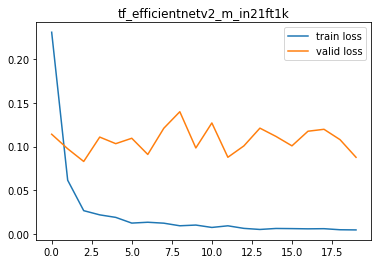

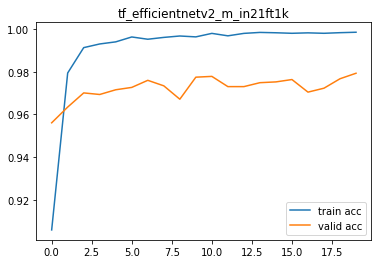

Epoch 0, Val loss: 0.8592105202751554, Acc: 0.8421052631578947, ROC: 0.9017252396166134
waiting...
flushing...
done!


In [62]:
#8
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [63]:
INDEX = 9

In [47]:
#9
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [48]:
#10
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [49]:
#11
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [50]:
"nvidia-smi --gpu-reset" "두근두근"

'nvidia-smi --gpu-reset두근두근'

# NFNet Family

In [88]:
print(len(NFN_BACKBONES))
print(NFN_BACKBONES)

4
['eca_nfnet_l1', 'eca_nfnet_l2', 'dm_nfnet_f0', 'dm_nfnet_f1']


In [89]:
INDEX = 0

In [ ]:
NFN_train_val_infer(NFN_BACKBONES[INDEX])

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.19071626073003714, Acc: 0.9234459570280465, ROC: 0.9802771016728989
Epoch 0, Val loss: 0.11305493552832914, Acc: 0.9623616236162361, ROC: 0.9949665878849248


  5%|▌         | 1/20 [22:32<7:08:19, 1352.62s/it]

Epoch 1, Train loss: 0.0717106149243918, Acc: 0.9777759553878956, ROC: 0.9971502451137633
Epoch 1, Val loss: 0.07327999445587705, Acc: 0.9745387453874539, ROC: 0.996564885708888


 10%|█         | 2/20 [45:05<6:45:46, 1352.56s/it]

Epoch 2, Train loss: 0.036698138727449016, Acc: 0.990405117270789, ROC: 0.9990660285047597
Epoch 2, Val loss: 0.05001989708174593, Acc: 0.9822878228782288, ROC: 0.9983571192520768


 15%|█▌        | 3/20 [1:07:36<6:23:02, 1351.93s/it]

Epoch 3, Train loss: 0.01771352273175666, Acc: 0.9957766114482532, ROC: 0.9997000290606523


 20%|██        | 4/20 [1:30:09<6:00:35, 1352.23s/it]

Epoch 3, Val loss: 0.05127259100940266, Acc: 0.981549815498155, ROC: 0.9981592825270047


In [ ]:
#0
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    eca_nfnet_l1    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.4061514938108408, Acc: 0.8146629489913072, ROC: 0.900396616392206
Epoch 0, Val loss: 0.29354710052528327, Acc: 0.8693726937269373, ROC: 0.9521485904272661


  5%|▌         | 1/20 [10:34<3:20:46, 634.02s/it]

Epoch 1, Train loss: 0.23597602964943554, Acc: 0.9049532556995243, ROC: 0.969931671825834
Epoch 1, Val loss: 0.2219913237281805, Acc: 0.9166051660516605, ROC: 0.9734185461619953


 10%|█         | 2/20 [21:03<3:09:27, 631.55s/it]

Epoch 2, Train loss: 0.1766432789643234, Acc: 0.9370182056749221, ROC: 0.9837865834572588
Epoch 2, Val loss: 0.1684007349275273, Acc: 0.944280442804428, ROC: 0.9852491823213101


 15%|█▌        | 3/20 [31:32<2:58:32, 630.16s/it]

In [ ]:
#1
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [77]:
#2
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    dm_nfnet_f0    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-dnf-weights/dm_nfnet_f0-604f9c3a.pth" to /home/ys/.cache/torch/hub/checkpoints/dm_nfnet_f0-604f9c3a.pth


In [78]:
INDEX = 3

In [ ]:
#3
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    dm_nfnet_f1    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-dnf-weights/dm_nfnet_f1-fc540f82.pth" to /home/ys/.cache/torch/hub/checkpoints/dm_nfnet_f1-fc540f82.pth


    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    eca_nfnet_l1    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.1738666056776346, Acc: 0.931851730359193, ROC: 0.9828681447829828
Epoch 0, Val loss: 0.08957250585459922, Acc: 0.970110701107011, ROC: 0.9950574255924931


  5%|▌         | 1/20 [09:40<3:03:56, 580.85s/it]

Epoch 1, Train loss: 0.048393052913625285, Acc: 0.9859767098573069, ROC: 0.9984297023260605
Epoch 1, Val loss: 0.06480597252489106, Acc: 0.9808118081180812, ROC: 0.9977496769131229


 10%|█         | 2/20 [19:19<2:53:47, 579.30s/it]

Epoch 2, Train loss: 0.012718927556545592, Acc: 0.9965146793505002, ROC: 0.9998895260361456
Epoch 2, Val loss: 0.06398327799066873, Acc: 0.9785977859778597, ROC: 0.9972470044454749


 15%|█▌        | 3/20 [28:57<2:44:04, 579.06s/it]

Epoch 3, Train loss: 0.004371295529502461, Acc: 0.9990979170083648, ROC: 0.9999447698986136
Epoch 3, Val loss: 0.059703303728803385, Acc: 0.9811808118081181, ROC: 0.9980612000942929


 20%|██        | 4/20 [38:36<2:34:24, 579.04s/it]

Epoch 4, Train loss: 0.0025718027656153044, Acc: 0.9993029358701, ROC: 0.99999529371006
Epoch 4, Val loss: 0.058516656668123244, Acc: 0.9874538745387453, ROC: 0.9975462673225557


 25%|██▌       | 5/20 [48:14<2:24:40, 578.70s/it]

Epoch 5, Train loss: 0.001863823461132564, Acc: 0.9995079547318353, ROC: 0.9999982179399204


 30%|███       | 6/20 [57:52<2:14:57, 578.36s/it]

Epoch 5, Val loss: 0.068285386569951, Acc: 0.9826568265682657, ROC: 0.9979034880007847
Epoch 6, Train loss: 0.0012101847066542245, Acc: 0.9997539773659176, ROC: 0.9999975780496215


 35%|███▌      | 7/20 [1:07:30<2:05:16, 578.18s/it]

Epoch 6, Val loss: 0.10031369272956536, Acc: 0.9856088560885609, ROC: 0.9976287457318816
Epoch 7, Train loss: 0.0011388740592915016, Acc: 0.9996719698212235, ROC: 0.9999993463486194


 40%|████      | 8/20 [1:17:13<1:55:57, 579.81s/it]

Epoch 7, Val loss: 0.07670560084572112, Acc: 0.985239852398524, ROC: 0.9972102235332079
Epoch 8, Train loss: 0.000727230107949572, Acc: 0.9997949811382647, ROC: 0.9999998211059379


 45%|████▌     | 9/20 [1:26:50<1:46:07, 578.88s/it]

Epoch 8, Val loss: 0.07194137961359802, Acc: 0.9859778597785978, ROC: 0.9978655925154187
Epoch 9, Train loss: 0.0006861498991963014, Acc: 0.9998359849106118, ROC: 0.9999994013929463


 50%|█████     | 10/20 [1:36:28<1:36:25, 578.57s/it]

Epoch 9, Val loss: 0.0900356554593864, Acc: 0.9870848708487084, ROC: 0.9971517084455105
Epoch 10, Train loss: 0.0014535740131073273, Acc: 0.9996719698212235, ROC: 0.9999493248166549


 55%|█████▌    | 11/20 [1:46:05<1:26:42, 578.08s/it]

Epoch 10, Val loss: 0.09077741260833233, Acc: 0.981549815498155, ROC: 0.9973389567261421
Epoch 11, Train loss: 0.0005882812745964999, Acc: 0.9998769886829588, ROC: 0.999999731658907


 60%|██████    | 12/20 [1:55:41<1:16:59, 577.38s/it]

Epoch 11, Val loss: 0.0682133891326563, Acc: 0.9863468634686346, ROC: 0.9978555613575277
Epoch 12, Train loss: 0.0003263991791463204, Acc: 0.9998769886829588, ROC: 0.9999999793583775


 65%|██████▌   | 13/20 [2:05:18<1:07:22, 577.48s/it]

Epoch 12, Val loss: 0.08380479698301843, Acc: 0.9845018450184502, ROC: 0.9973517743167806
Epoch 13, Train loss: 0.0010345538469003382, Acc: 0.9998769886829588, ROC: 0.999987559982147


 70%|███████   | 14/20 [2:14:01<56:05, 560.93s/it]  

Epoch 13, Val loss: 0.07662474675521426, Acc: 0.9867158671586715, ROC: 0.9980194036030806
Epoch 14, Train loss: 0.0005579091441351907, Acc: 0.9998769886829588, ROC: 0.9999993945124054


 75%|███████▌  | 15/20 [2:24:39<48:40, 584.06s/it]

Epoch 14, Val loss: 0.07514675987695711, Acc: 0.9837638376383764, ROC: 0.997910732725928
Epoch 15, Train loss: 0.0005855783556296988, Acc: 0.9997539773659176, ROC: 0.9999998555086422


 80%|████████  | 16/20 [2:35:17<40:01, 600.39s/it]

Epoch 15, Val loss: 0.09398560375752332, Acc: 0.9848708487084871, ROC: 0.9975267622933233
Epoch 16, Train loss: 0.0005098481059886274, Acc: 0.9997949811382647, ROC: 0.999999910552969


 85%|████████▌ | 17/20 [2:45:56<30:36, 612.05s/it]

Epoch 16, Val loss: 0.07649814928544309, Acc: 0.9848708487084871, ROC: 0.998013273451036
Epoch 17, Train loss: 0.0004240296807133954, Acc: 0.9999589962276529, ROC: 0.9999979840015316


 90%|█████████ | 18/20 [2:55:01<19:43, 591.74s/it]

Epoch 17, Val loss: 0.08664774659940205, Acc: 0.9870848708487084, ROC: 0.9977078804219106
Epoch 18, Train loss: 0.0005337558629919142, Acc: 0.9999179924553059, ROC: 0.9999981628955936


 95%|█████████▌| 19/20 [3:01:52<08:57, 537.39s/it]

Epoch 18, Val loss: 0.09090435910400183, Acc: 0.9867158671586715, ROC: 0.9975791472289762
Epoch 19, Train loss: 0.0008661067666474777, Acc: 0.9998359849106118, ROC: 0.9999909314471624


100%|██████████| 20/20 [3:08:45<00:00, 566.26s/it]

Epoch 19, Val loss: 0.11893650438860776, Acc: 0.9837638376383764, ROC: 0.9962773258493465


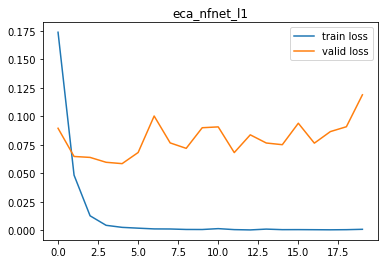

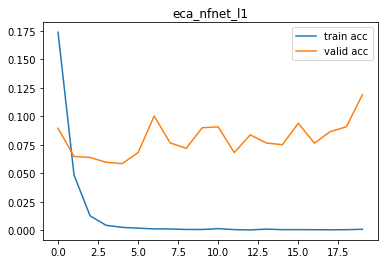

Epoch 0, Val loss: 0.7536699795418826, Acc: 0.8586744639376218, ROC: 0.9287659744408946
waiting...
flushing...
done!


In [49]:
#4
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

# DEIT Couple

In [ ]:
# need to resize image for using this

In [ ]:
DEIT_BACKBONES

In [ ]:
# DEIT_train_val_infer(DEIT_BACKBONES[1])